In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import numpy as np
import pandas as pd
import os

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from PIL import Image
import matplotlib.pyplot as plt
image_file = './MTCNN/angelina_jolie/1.jpg'
image = Image.open(image_file)

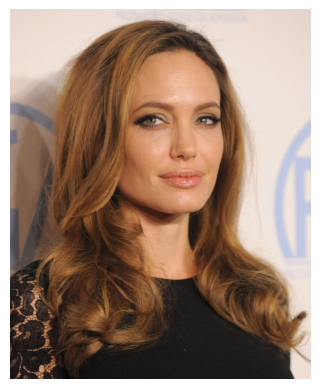

In [3]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
mtcnn = MTCNN(
    image_size=160, margin=0, min_face_size=20,
    thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
    device=device
)

In [6]:
image_cropped = mtcnn(image)
image_cropped = torch.permute(image_cropped, (1, 2, 0))
image_cropped = image_cropped.clamp(-1, 1)
image_cropped = (image_cropped + 1) *.5

In [8]:
type(image_cropped)

torch.Tensor

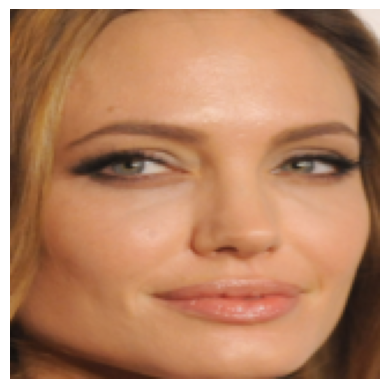

In [9]:
plt.imshow(image_cropped)
plt.axis('off')
plt.show()

In [10]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)


  0%|          | 0.00/107M [00:00<?, ?B/s]

In [14]:
def collate_fn(x):
    return x[0]
dataset = datasets.ImageFolder('./MTCNN')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
loader = DataLoader(dataset, collate_fn=collate_fn)


In [26]:
aligned = []
names = []
for x, y in loader:
    x_aligned, prob = mtcnn(x, return_prob = True)
    if x_aligned is not None:
        print(f'臉部識別的機率: {prob:8f}')
        aligned.append(x_aligned)
        
        names.append(dataset.idx_to_class[y])

臉部識別的機率: 0.999983
臉部識別的機率: 0.999934
臉部識別的機率: 0.999733
臉部識別的機率: 0.999880
臉部識別的機率: 0.999992


In [31]:
aligned = torch.stack(aligned).to(device)
embeddings = resnet(aligned).detach().cpu()

In [35]:
dists = [[(e1 - e2).norm().item() for e2 in embeddings] for e1 in embeddings]
pd.DataFrame(dists, columns = names, index = names)

,angelina_jolie,bradley_cooper,kate_siegel,paul_rudd,shea_whigham
angelina_jolie,0.000000,1.447480,0.887728,1.429847,1.399073
bradley_cooper,1.447480,0.000000,1.313749,1.013447,1.038684
kate_siegel,0.887728,1.313749,0.000000,1.388377,1.379655
paul_rudd,1.429847,1.013447,1.388377,0.000000,1.100503
shea_whigham,1.399073,1.038684,1.379655,1.100503,0.000000


In [38]:
import mmcv, cv2
from PIL import Image, ImageDraw
from IPython import display

No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.6'
C:\Users\ian\anaconda3\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [40]:
mtcnn = MTCNN(keep_all=True, device=device)


In [42]:
video_path = './MTCNN/video.mp4'
video = mmcv.VideoReader(video_path)
frames = [Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) 
          for frame in video]

display.Video(video_path, width=640)

In [51]:
frames_tracked = []
for i, frame in enumerate(frames):
    print('\rTracking frame: {}'.format(i + 1), end = '')
    boxes, _ = mtcnn.detect(frame)
    frame_draw = frame.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box.tolist(), outline=(255, 0, 0), width=6)
        
    frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))
print('\nDone')


Tracking frame: 1

C:\Users\ian\AppData\Local\Temp\ipykernel_2700\805518189.py:10: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  frames_tracked.append(frame_draw.resize((640, 360), Image.BILINEAR))


Tracking frame: 105
Done


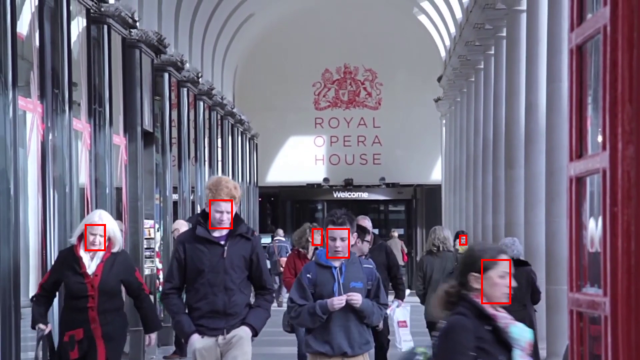

In [56]:
d = display.display(frames_tracked[0], display_id=True)
i = 1
try:
    while True:
        d.update(frames_tracked[i % len(frames_tracked)])
        i += 1
except KeyboardInterrupt:
    pass


In [55]:
dim = frames_tracked[0].size
fourcc = cv2.VideoWriter_fourcc(*'FMP4')    
video_tracked = cv2.VideoWriter('video_tracked.mp4', fourcc, 25.0, dim)
for frame in frames_tracked:
    video_tracked.write(cv2.cvtColor(np.array(frame), cv2.COLOR_RGB2BGR))
video_tracked.release()

(640, 360)